<a href="https://colab.research.google.com/github/AmirMAAI/Spaceship_Titanic/blob/main/spaceship_titanic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRM0nCU7nbBzEKPg7RdAUe1sJM98rGo8FJSQQIdgj1rA0IrwBFf2fzw1oLAnK65pSvaBjk&usqp=CAU" width=500 height=500 />
</center>

<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix,accuracy_score

<a id="1"></a> <br>
# 2. Import Dataset

In [120]:
df_train = pd.read_csv('/content/spaceship_titanic_train.csv')
df_test = pd.read_csv('/content/spaceship_titanic_test.csv')
df_data = pd.concat([df_train,df_test]).reset_index(drop=True)

In [121]:
df_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<span style="font-family:cursive; color:black;font-size:16px">

Feature descriptions:</span>

> * **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
> * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> * **Destination** - The planet the passenger will be debarking to.
> * **Age** - The age of the passenger.
> * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
> * **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> * **Name** - The first and last names of the passenger.
> * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Missing values**

In [122]:
df_data.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

**Duplicates**

In [123]:
print('Sum Of Duplicated Data : {}'.format(df_data.duplicated().sum()))

Sum Of Duplicated Data : 0


**Cardinality of features**

In [124]:
df_data.nunique()

PassengerId     12970
HomePlanet          3
CryoSleep           2
Cabin            9825
Destination         3
Age                80
VIP                 2
RoomService      1578
FoodCourt        1953
ShoppingMall     1367
Spa              1679
VRDeck           1642
Name            12629
Transported         2
dtype: int64

**Data types**

In [125]:
df_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

Machine learning models usually do not work on text, so we need to convert the data into numeric (int64 or float64). This will be done later.

<a id="1"></a> <br>
# 3. Exploratory Data Analysis

Text(0.5, 1.0, 'Target distribution')

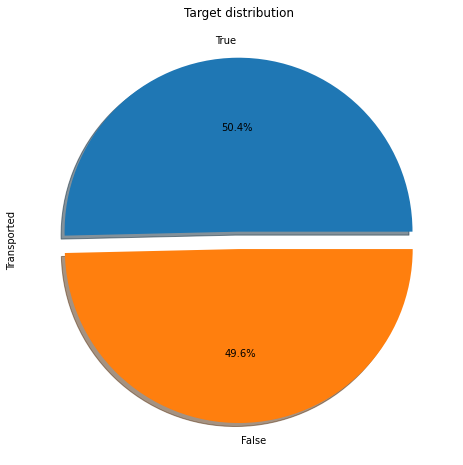

In [126]:
# Figure size
plt.figure(figsize=(8,8))

# Pie plot
df_train.Transported.value_counts().plot(kind='pie',shadow=True,explode=[0.05,0.05],autopct='%1.1f%%').set_title("Target distribution")

**Continuous features**

Text(0.5, 0, 'Age (years)')

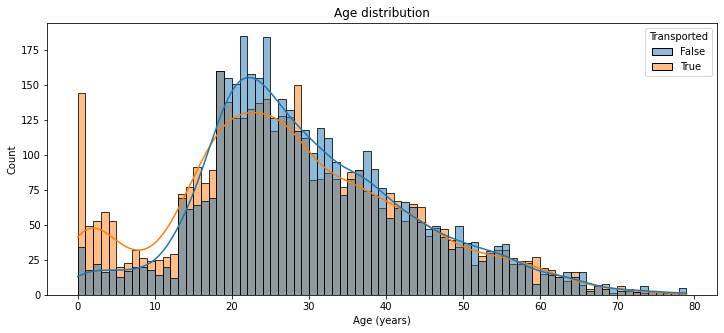

In [127]:
# Figure size
plt.figure(figsize=(12,5))

# Histogram
sns.histplot(x='Age', hue='Transported',data=df_train, kde=True, binwidth=1)
plt.title('Age distribution')
plt.xlabel('Age (years)')

As we can see : 
* 0-18 year olds were **more** likely to be transported than not.
* 18-25 year olds were **less** likely to be transported than not.
* Over 25 year olds were about **equally** likely to be transported than not.

So we can Create a new feature that indicates whether the passanger is a child, adolescent or adult.

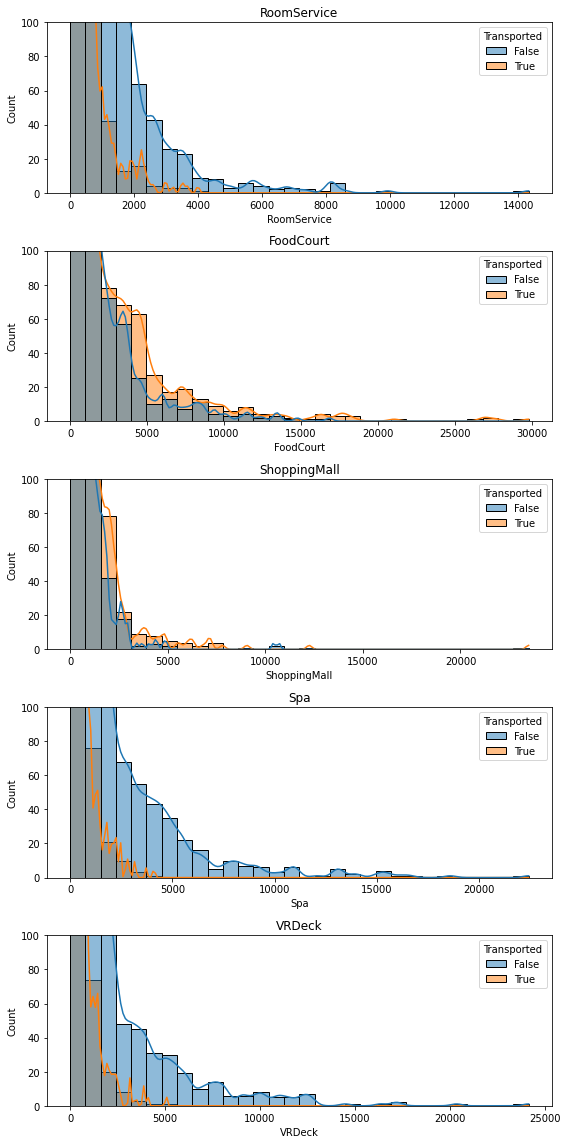

In [128]:
# Cost features
cost_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot Cost features
fig=plt.figure(figsize=(8,16))
for i,feature in enumerate(cost_features):
    ax=fig.add_subplot(5,1,i+1)
    sns.histplot(x= feature,data=df_train, hue ='Transported', bins=30,kde=True, axes=ax)
    plt.ylim([0,100])
    ax.set_title(feature)
fig.tight_layout()  # Improves appearance a bit
plt.show()        

As we can see:
* Most people don't spend any money and People who were transported tended to spend less.
* RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall .

**Categorical features**

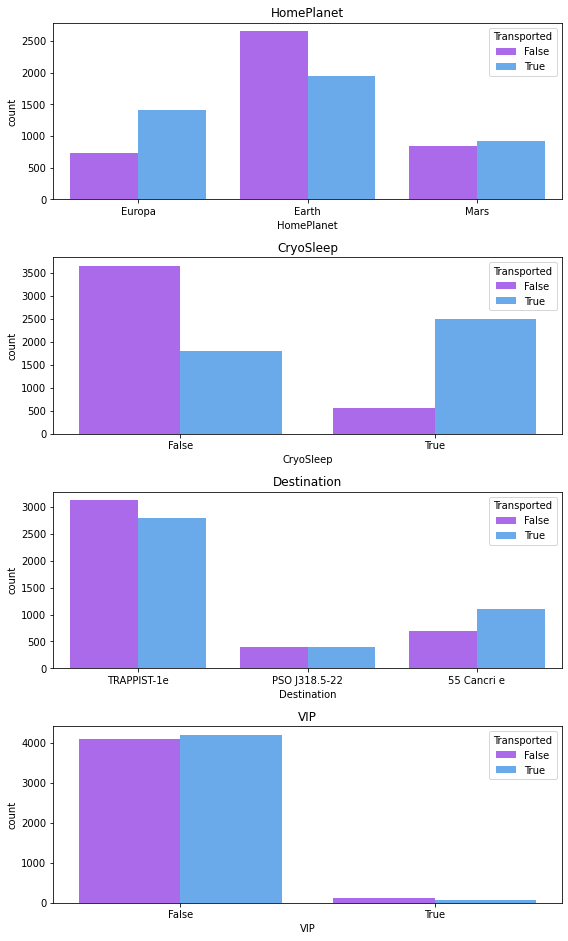

In [129]:
# Categorical features
Catego_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(8,16))
for i,feature in enumerate(Catego_features):
    ax=fig.add_subplot(5,1,i+1)
    sns.countplot(x= feature,data=df_train, hue ='Transported', axes=ax,palette = "cool_r")
    ax.set_title(feature)
fig.tight_layout()  # Improves appearance a bit
plt.show()   

As we can see:
* VIP does not appear to be a useful feature whereas CryoSleep appears the be a very useful feature in contrast.

<a id="1"></a> <br>
# 4. Feature engineering

Bin age feature into groups. This will be helpful for filling missing values.

In [130]:
# New feature--Age_group
df_data['Age_group']=np.nan
df_data['Age_group'] = df_data['Age'].apply(lambda x: '-12_Age' if x<12 else
                                            '12-18_Age' if (x>=12) & (x<18) else
                                            '18-25_Age' if (x>=18) & (x<25) else
                                            '25-35_Age' if (x>=25) & (x<35) else
                                            '35-50_Age' if (x>=35) & (x<50) else
                                            '+50_Age' if x>=50 else None)

Text(0.5, 1.0, 'Age group distribution')

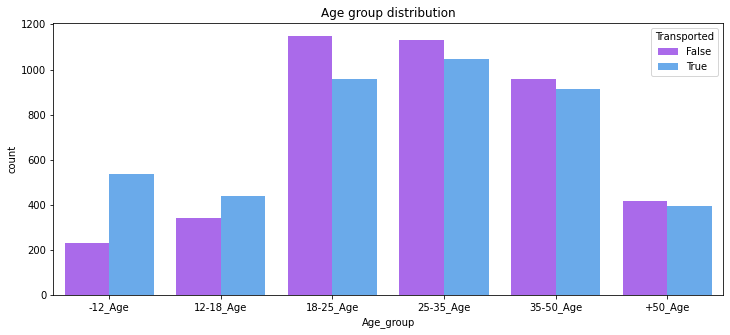

In [131]:
# Plot distribution of Age_group feature
plt.figure(figsize=(12,5))
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Age_group', hue='Transported', order=['-12_Age','12-18_Age','18-25_Age','25-35_Age','35-50_Age','+50_Age'])
plt.title('Age group distribution')

In [132]:
# New features --Cost and No_Cost
df_data['Cost'] = df_data[cost_features].sum(axis=1)
df_data['No_Cost'] = df_data['Cost'].apply(lambda x: 1 if x==0 else 0 ).astype(int)

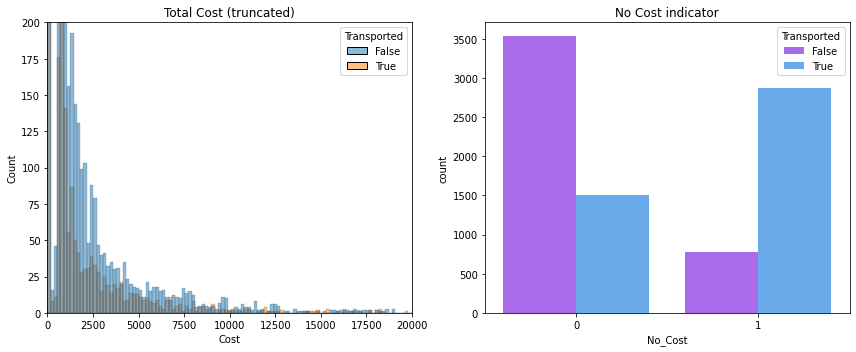

In [133]:
# Plot distribution of Cost and No_Cost features 
fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df_data[df_data.Transported.isnull()==False], x='Cost', hue='Transported', bins=200)
plt.title('Total Cost (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='No_Cost', hue='Transported')
plt.title('No Cost indicator')
fig.tight_layout()

Extract passenger group and group size from PassengerId.

In [134]:
# New features --Passenger_Group and Passenger_Group_Size
df_data['Passenger_Group'] = df_data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
df_data['Passenger_Group_Size'] = df_data['Passenger_Group'].apply(lambda x: df_data['Passenger_Group'].value_counts()[x])

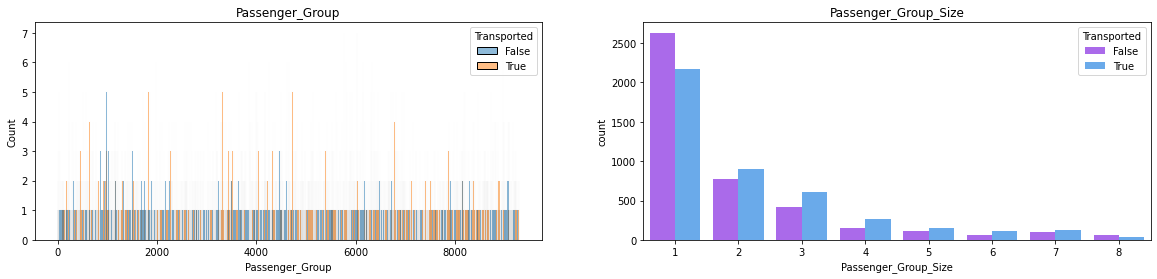

In [135]:
# Plot distribution of 'Passenger_Group and Passenger_Group_Size features 
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=df_data[df_data.Transported.isnull()==False], x='Passenger_Group', hue='Transported', binwidth=1)
plt.title('Passenger_Group')

plt.subplot(1,2,2)
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Passenger_Group_Size', hue='Transported')
plt.title('Passenger_Group_Size')
fig.tight_layout()

In [136]:
# New feature --Alone
df_data['Alone']= (df_data['Passenger_Group_Size']==1).astype(int)

(0.0, 3000.0)

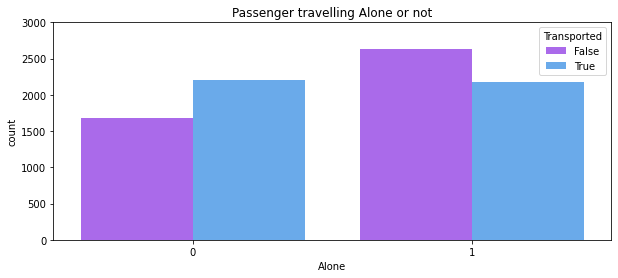

In [137]:
# Plot distribution of Alone feature
plt.figure(figsize=(10,4))
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Alone', hue='Transported')
plt.title('Passenger travelling Alone or not')
plt.ylim([0,3000])

Extract deck, number and side from cabin feature.

In [138]:
# Replace NaN's with outliers for now
df_data['Cabin'].fillna('Z/9999/Z',inplace=True)

In [139]:
# New features --Cabin_deck, Cabin_number and Cabin_side features
df_data['Cabin_deck'] = df_data['Cabin'].apply(lambda x: x.split('/')[0])
df_data['Cabin_number'] = df_data['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
df_data['Cabin_side'] = df_data['Cabin'].apply(lambda x: x.split('/')[2])

In [140]:
# Put Nan's back in (we will fill these later)
df_data.loc[df_data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
df_data.loc[df_data['Cabin_number']==9999, 'Cabin_number']=np.nan
df_data.loc[df_data['Cabin_side']=='Z', 'Cabin_side']=np.nan

In [141]:
# Drop Cabin feature
df_data.drop('Cabin',axis=1, inplace=True)

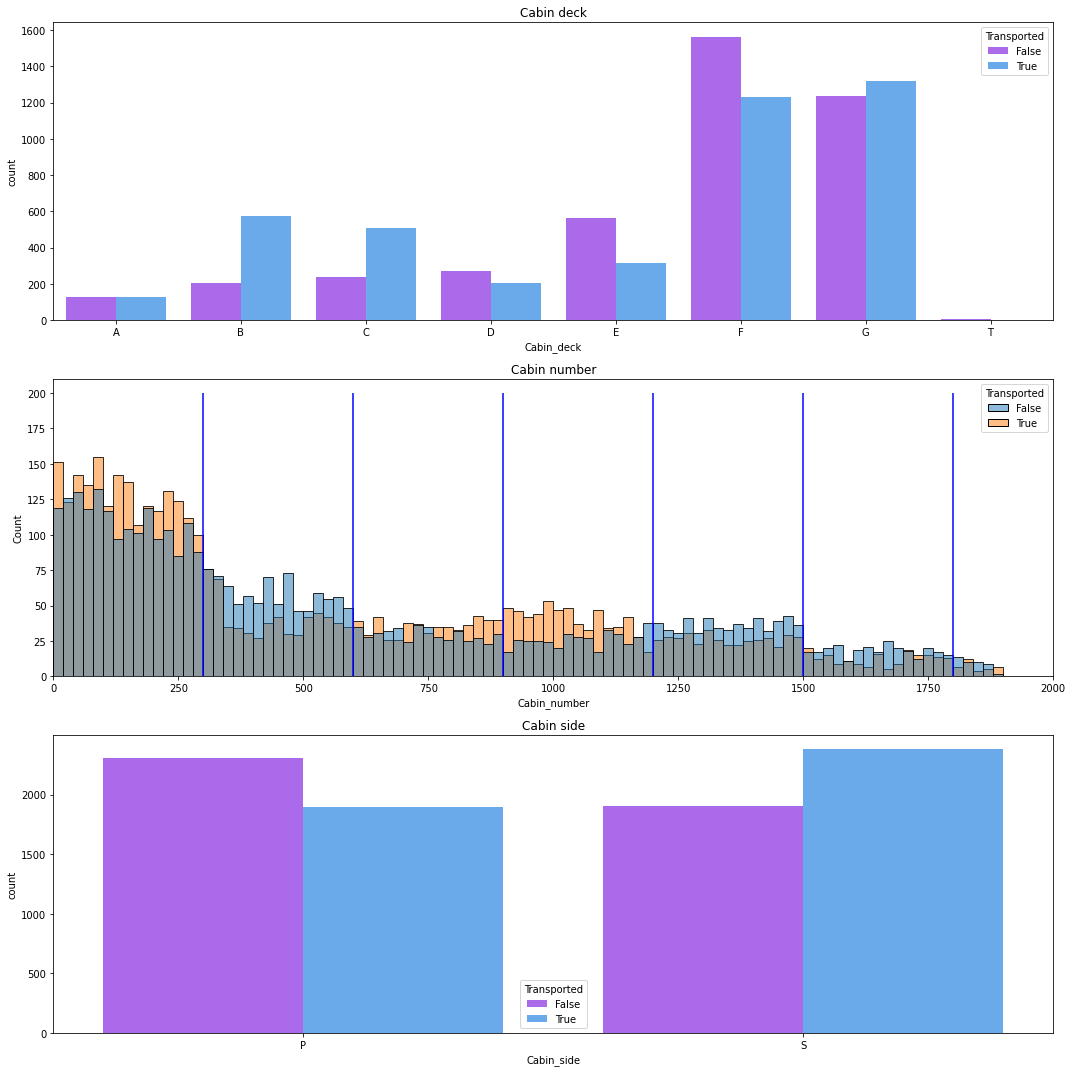

In [142]:
# Plot distribution of Cabin_deck,Cabin_number and Cabin_side features
fig=plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=df_data[df_data.Transported.isnull()==False], x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='blue')
plt.vlines(600, ymin=0, ymax=200, color='blue')
plt.vlines(900, ymin=0, ymax=200, color='blue')
plt.vlines(1200, ymin=0, ymax=200, color='blue')
plt.vlines(1500, ymin=0, ymax=200, color='blue')
plt.vlines(1800, ymin=0, ymax=200, color='blue')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

As we can see from Cabin_number is grouped into Collections of 300 cabins. This means we can compress this feature into a categorical one, which indicates which Collection each passenger is in. Furthermore ، The cabin deck 'T' seems to be an outlier.

In [143]:
# New features 
df_data['Cabin_Part1']=(df_data['Cabin_number']<300).astype(int)   # one-hot encoding
df_data['Cabin_Part2']=((df_data['Cabin_number']>=300) & (df_data['Cabin_number']<600)).astype(int)
df_data['Cabin_Part3']=((df_data['Cabin_number']>=600) & (df_data['Cabin_number']<900)).astype(int)
df_data['Cabin_Part4']=((df_data['Cabin_number']>=900) & (df_data['Cabin_number']<1200)).astype(int)
df_data['Cabin_Part5']=((df_data['Cabin_number']>=1200) & (df_data['Cabin_number']<1500)).astype(int)
df_data['Cabin_Part6']=((df_data['Cabin_number']>=1500) & (df_data['Cabin_number']<1800)).astype(int)
df_data['Cabin_Part7']=(df_data['Cabin_number']>=1800).astype(int)

**Last name**

In [144]:
# Replace NaN's with outliers for now 
df_data['Name'].replace(np.nan,'Unknown Unknown', inplace=True)

# New feature - Last_Name
df_data['Last_Name']=df_data['Name'].apply(lambda x: x.split()[1])

# New feature - 'Family_Size
df_data['Family_Size'] = df_data['Last_Name'].apply(lambda x: df_data['Last_Name'].value_counts()[x])

In [145]:
# Put Nan's back in (we will fill these later)
df_data['Last_Name'].replace('Unknown',np.nan,inplace=True)
df_data.loc[df_data['Family_Size']>100,'Family_Size']=np.nan

In [146]:
# Drop name feature
df_data.drop('Name',axis=1, inplace=True)

Text(0.5, 1.0, 'Family Size')

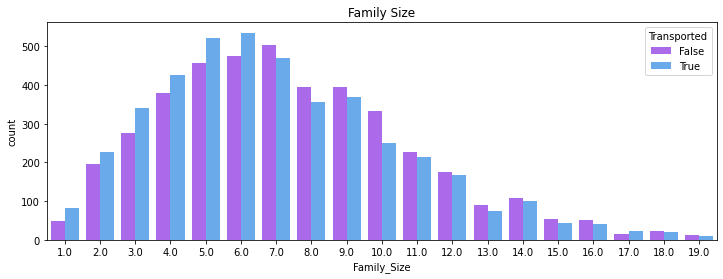

In [147]:
# Plot distribution of Family_Size feature
plt.figure(figsize=(12,4))
sns.countplot(data=df_data[df_data.Transported.isnull()==False],palette = "cool_r", x='Family_Size', hue='Transported')
plt.title('Family Size')

<a id="1"></a> <br>
# 5. Missing Values

In [148]:
df_data.isnull().sum()

PassengerId                0
HomePlanet               288
CryoSleep                310
Destination              274
Age                      270
VIP                      296
RoomService              263
FoodCourt                289
ShoppingMall             306
Spa                      284
VRDeck                   268
Transported             4277
Age_group                270
Cost                       0
No_Cost                    0
Passenger_Group            0
Passenger_Group_Size       0
Alone                      0
Cabin_deck               299
Cabin_number             299
Cabin_side               299
Cabin_Part1                0
Cabin_Part2                0
Cabin_Part3                0
Cabin_Part4                0
Cabin_Part5                0
Cabin_Part6                0
Cabin_Part7                0
Last_Name                294
Family_Size              294
dtype: int64

In [149]:
missing_values = [col for col in df_data.columns if df_data[col].isnull().any()]
missing_values.remove('Transported')
S=pd.DataFrame(df_data[missing_values].isnull().sum(), columns=['Number Of Missing'])
S['Percentage Of Missing'] = np.round(S['Number Of Missing'].apply(lambda x: x*100/len(df_data)),2)
S

,Number Of Missing,Percentage Of Missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


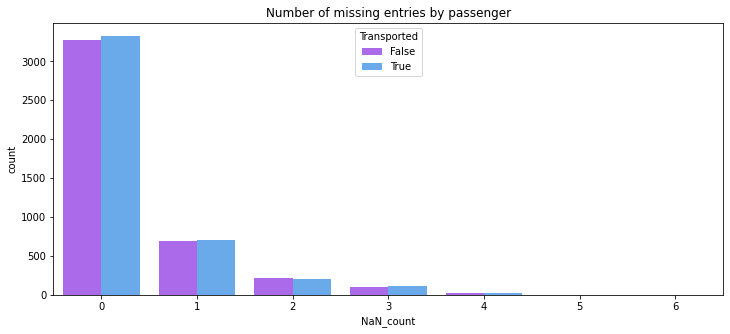

In [150]:
# Countplot of number of missing values by passenger
df_data['NaN_count']=df_data.isnull().sum(axis=1)
plt.figure(figsize=(12,5))
sns.countplot(data=df_data, x='NaN_count', hue='Transported',palette = "cool_r")
plt.title('Number of missing entries by passenger')
df_data.drop('NaN_count', axis=1, inplace=True)

*As we can see:*

Missing values are independent of the target and about 25% of all passengers have at least 1 missing value.

The **easiest** way to deal with missing values is to just use the **median** for continuous features and the **mode** for categorical features but To improve accuracy of our models then we need to look for patterns within the missing data. The way to do this is by looking at the **joint distribution** of features.

**HomePlanet:**

**HomePlanet and Passenger_Group**


In [151]:
# Joint distribution of Passenger_Group and HomePlanet
idx1 = df_data.groupby(['Passenger_Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0).astype(int)
idx1.head()

HomePlanet,Earth,Europa,Mars
Passenger_Group,,,
1,0,1,0
2,1,0,0
3,0,2,0
4,1,0,0
5,1,0,0


Text(0.5, 1.0, 'Number of unique home planets per group')

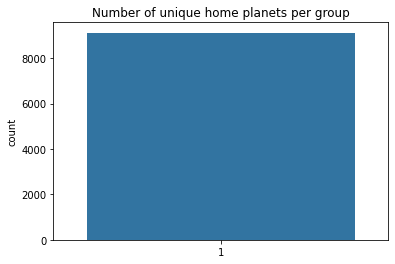

In [152]:
sns.countplot((idx1>0).sum(axis=1))
plt.title('Number of unique home planets per group')

This shows that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to the group.

In [153]:
# Missing values before
before_HomePlanet_miss = df_data.HomePlanet.isnull().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
idx2=df_data[df_data.HomePlanet.isnull()][(df_data[df_data.HomePlanet.isnull()]['Passenger_Group']).isin(idx1.index)].index

# Fill corresponding missing values
df_data.loc[idx2,'HomePlanet'] = df_data.loc[idx2,'Passenger_Group'].map(lambda x: idx1.idxmax(axis=1)[x])

# Print number of missing values left
print('Number of HomePlanet missing values before:',before_HomePlanet_miss)
print('Number of HomePlanet missing values after:',df_data['HomePlanet'].isnull().sum())

Number of HomePlanet missing values before: 288
Number of HomePlanet missing values after: 157


**HomePlanet and CabinDeck**

In [154]:
# Joint distribution of Cabin_deck and HomePlanet
idx3 = df_data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0).astype(int)
idx3.head()

HomePlanet,Earth,Europa,Mars
Cabin_deck,,,
A,0,352,0
B,0,1137,0
C,0,1096,0
D,0,301,410
E,589,199,515


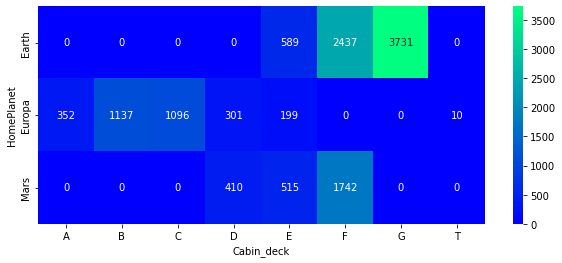

In [155]:
# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(idx3.T, annot=True, fmt='g', cmap='winter')

*As we can see:*
* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.
* Passengers on decks D, E or F came from multiple planets.

In [156]:
# Missing values before
before_HomePlanet_miss = df_data.HomePlanet.isnull().sum()

# For Decks A, B, C or T 
df_data.loc[(df_data.HomePlanet.isnull()) & (df_data.Cabin_deck.isin(['A','B','C','T'])), 'HomePlanet' ]='Europa'

# For Deck G
df_data.loc[(df_data.HomePlanet.isnull()) & (df_data.Cabin_deck=='G'), 'HomePlanet' ]='Earth'

# Print number of missing values left
print('Number of HomePlanet missing values before:',before_HomePlanet_miss)
print('Number of HomePlanet missing values after:',df_data['HomePlanet'].isnull().sum())

Number of HomePlanet missing values before: 157
Number of HomePlanet missing values after: 94


**HomePlanet and Last_Name**

In [157]:
# Joint distribution of Last_Name and HomePlanet
idx4=df_data.groupby(['Last_Name','HomePlanet'])['HomePlanet'].size().unstack().fillna(0).astype(int)
idx4.head()

HomePlanet,Earth,Europa,Mars
Last_Name,,,
Acobson,5,0,0
Acobsond,8,0,0
Adavisons,10,0,0
Adkinson,4,0,0
Admingried,0,4,0


Text(0.5, 1.0, 'Number of unique planets per LastName')

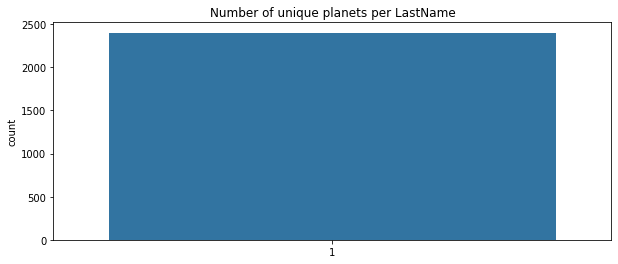

In [158]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((idx4>0).sum(axis=1))
plt.title('Number of unique planets per LastName')

**Excellent!** Everyone with the same LastName comes from the same home planet.

In [159]:
# Missing values before
before_HomePlanet_miss = df_data.HomePlanet.isnull().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
idx5=df_data[df_data['HomePlanet'].isna()][(df_data[df_data['HomePlanet'].isna()]['Last_Name']).isin(idx4.index)].index

# Fill corresponding missing values
df_data.loc[idx5,'HomePlanet']=df_data.iloc[idx5,:]['Last_Name'].map(lambda x: idx4.idxmax(axis=1)[x])

# Print number of missing values left
print('Number of HomePlanet missing values before:',before_HomePlanet_miss)
print('Number of HomePlanet missing values after:',df_data['HomePlanet'].isnull().sum())

Number of HomePlanet missing values before: 94
Number of HomePlanet missing values after: 10


In [160]:
# Only 10 HomePlanet missing values remain.
df_data.loc[df_data.HomePlanet.isnull(),['PassengerId','HomePlanet','Destination','Cabin_deck']]

,PassengerId,HomePlanet,Destination,Cabin_deck
2274,2443_01,NaN,TRAPPIST-1e,D
2631,2817_01,NaN,TRAPPIST-1e,F
3091,3331_01,NaN,TRAPPIST-1e,F
4548,4840_01,NaN,TRAPPIST-1e,F
5762,6108_01,NaN,TRAPPIST-1e,F
8969,0616_01,NaN,TRAPPIST-1e,E
10583,4052_01,NaN,TRAPPIST-1e,D
11913,7065_01,NaN,TRAPPIST-1e,E
12551,8435_01,NaN,TRAPPIST-1e,F
12725,8775_01,NaN,TRAPPIST-1e,D


In [161]:
# Joint distribution of Last_Name and HomePlanet
idx5=df_data.groupby(['Destination','HomePlanet'])['HomePlanet'].size().unstack().fillna(0).astype(int)
idx5.head()

HomePlanet,Earth,Europa,Mars
Destination,,,
55 Cancri e,1000,1341,300
PSO J318.5-22,1085,29,70
TRAPPIST-1e,4778,1769,2314


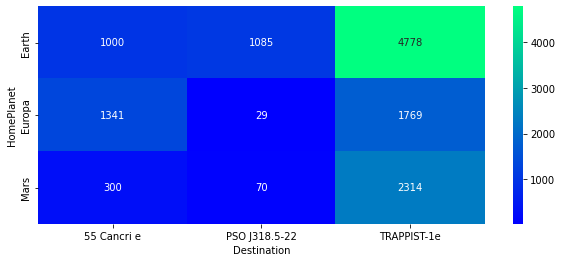

In [162]:
# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(idx5.T, annot=True, fmt='g', cmap='winter')

Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But remember from earlier, no one on deck D came from Earth so we need to filter these out.

In [163]:
# Missing values before
before_HomePlanet_miss = df_data.HomePlanet.isnull().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
df_data.loc[(df_data.HomePlanet.isnull()) & (df_data.Cabin_deck != 'D'),'HomePlanet']='Earth'
df_data.loc[(df_data.HomePlanet.isnull()) & (df_data.Cabin_deck == 'D'),'HomePlanet']='Mars'

# Print number of missing values left
print('Number of HomePlanet missing values before:',before_HomePlanet_miss)
print('Number of HomePlanet missing values after:',df_data['HomePlanet'].isnull().sum())

Number of HomePlanet missing values before: 10
Number of HomePlanet missing values after: 0


**Great**. mission (Missing Values for HomePlanet) complete .

**Destination:**

In [164]:
df_data.Destination.value_counts()/len(df_data.Destination) * 100

TRAPPIST-1e      68.396299
55 Cancri e      20.362375
PSO J318.5-22     9.128759
Name: Destination, dtype: float64

Since about 68% of the destination Column is related to TRAPPIST-1e, So we use the mode to fill the missing values.

In [165]:
# Missing values before
before_destination_miss=df_data['Destination'].isnull().sum()

# Fill missing Destination values with mode
df_data.loc[(df_data['Destination'].isnull()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('Number of Destination missing values before:',before_destination_miss)
print('Number of Destination missing values after:',df_data['Destination'].isnull().sum())

Number of Destination missing values before: 274
Number of Destination missing values after: 0


**Last_Name and Passenger_Group:**

The reason we are filling missing Last Names is because we will use Last Names later to fill missing values of other features. It also means we can improve the accuracy of the family size featue.

In [166]:
idx6 = df_data[df_data.Passenger_Group_Size>1].groupby(['Passenger_Group','Last_Name']).size().unstack().fillna(0).astype(int)
idx6.head()

Last_Name,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Woody,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes
Passenger_Group,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Number of unique Last Name by Passenger Group')

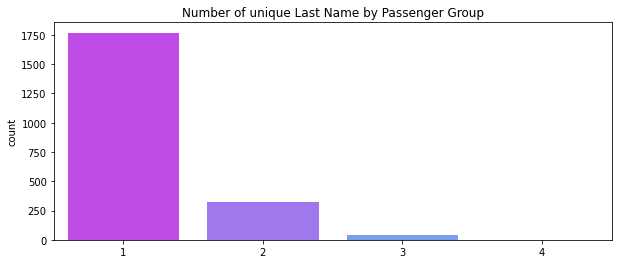

In [167]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((idx6>0).sum(axis=1),palette = "cool_r")
plt.title('Number of unique Last Name by Passenger Group')

The majority (83%) of groups contain only 1 family. So let's fill missing Last_Name according to the majority Last_Name in that Passenger Group.

In [168]:
# Missing values before
before_Last_Name_miss=df_data['Last_Name'].isnull().sum()

# Passengers with missing Last Name and in a Passenger Group with known majority Last Name
idx7=df_data[df_data['Last_Name'].isna()][(df_data[df_data['Last_Name'].isna()]['Passenger_Group']).isin(idx6.index)].index

# Fill corresponding missing values
df_data.loc[idx7,'Last_Name']=df_data.iloc[idx7,:]['Passenger_Group'].map(lambda x: idx6.idxmax(axis=1)[x])

# Print number of missing values left
print('Number of Last_Name missing values before:',before_Last_Name_miss)
print('Number of Last_Name missing values after:',df_data['Last_Name'].isnull().sum())

Number of Last_Name missing values before: 294
Number of Last_Name missing values after: 155


That is the best we can do. We don't have to get rid of all of these missing values because we will end up dropping the Last_Name feature anyway. However, we can update the family size feature.

In [169]:
df_data.isnull().sum()

PassengerId                0
HomePlanet                 0
CryoSleep                310
Destination                0
Age                      270
VIP                      296
RoomService              263
FoodCourt                289
ShoppingMall             306
Spa                      284
VRDeck                   268
Transported             4277
Age_group                270
Cost                       0
No_Cost                    0
Passenger_Group            0
Passenger_Group_Size       0
Alone                      0
Cabin_deck               299
Cabin_number             299
Cabin_side               299
Cabin_Part1                0
Cabin_Part2                0
Cabin_Part3                0
Cabin_Part4                0
Cabin_Part5                0
Cabin_Part6                0
Cabin_Part7                0
Last_Name                155
Family_Size              294
dtype: int64

In [170]:
# fills NaN's 
df_data['Last_Name'].fillna('Unknown', inplace=True)

# Update family size feature
df_data['Family_Size'] = df_data['Last_Name'].apply(lambda x: df_data['Last_Name'].value_counts()[x])

# Put NaN's back in place of outliers
df_data.loc[df_data['Last_Name']=='Unknown','Last_Name']=np.nan

# Say unknown Last Name means no family
df_data.loc[df_data['Family_Size']>100,'Family_Size']=0

**Cabin_side and Passenger_Group:**

In [171]:
# Joint distribution of Passenger Group and Cabin features
j1=df_data[df_data['Passenger_Group_Size']>1].groupby(['Passenger_Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0).astype(int)
j2=df_data[df_data['Passenger_Group_Size']>1].groupby(['Passenger_Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0).astype(int)
j3=df_data[df_data['Passenger_Group_Size']>1].groupby(['Passenger_Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0).astype(int)

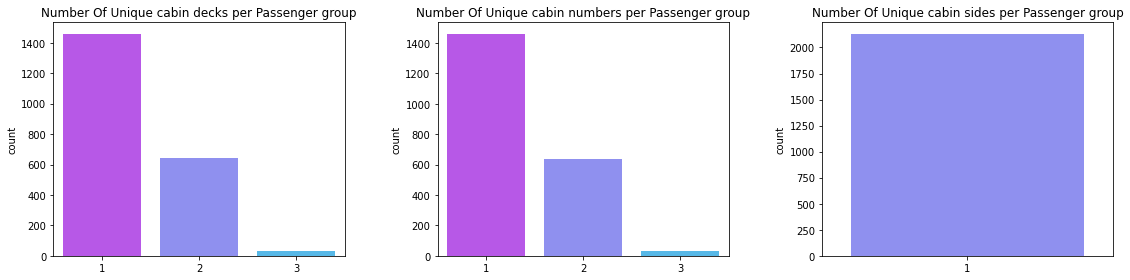

In [172]:
# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((j1>0).sum(axis=1),palette = "cool_r")
plt.title('Number Of Unique cabin decks per Passenger group')

plt.subplot(1,3,2)
sns.countplot((j2>0).sum(axis=1),palette = "cool_r")
plt.title('Number Of Unique cabin numbers per Passenger group')

plt.subplot(1,3,3)
sns.countplot((j3>0).sum(axis=1),palette = "cool_r")
plt.title('Number Of Unique cabin sides per Passenger group')
fig.tight_layout()

In [173]:
# Missing values before
before_Cabin_side_miss=df_data['Cabin_side'].isnull().sum()

# Passengers with missing Cabin side and in a Passenger Group with known majority Cabin side
idx8=df_data[df_data['Cabin_side'].isna()][(df_data[df_data['Cabin_side'].isna()]['Passenger_Group']).isin(j3.index)].index

# Fill corresponding missing values
df_data.loc[idx8,'Cabin_side']=df_data.iloc[idx8,:]['Passenger_Group'].map(lambda x: j3.idxmax(axis=1)[x])

# Print number of missing values left
print('Number of Cabin_side missing values before:',before_Cabin_side_miss)
print('Number of Cabin_side missing values after:',df_data['Cabin_side'].isnull().sum())

Number of Cabin_side missing values before: 299
Number of Cabin_side missing values after: 162


**Cabin_side and Last_Name:**

In [174]:
# Joint distribution of Last name and Cabin side
idx9=df_data[df_data['Passenger_Group_Size']>1].groupby(['Last_Name','Cabin_side'])['Cabin_side'].size().unstack().fillna(0).astype(int)
idx9.head()

Cabin_side,P,S
Last_Name,,
Acobson,0,3
Acobsond,3,0
Adavisons,6,0
Admingried,0,4
Aginge,3,0


Text(0.5, 1.0, 'Number of unique Last Name by Passenger Group')

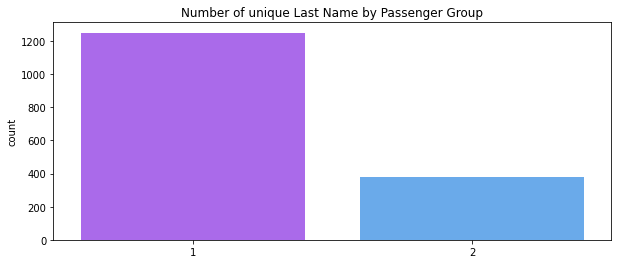

In [175]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((idx9>0).sum(axis=1),palette = "cool_r")
plt.title('Number of unique Last Name by Passenger Group')

The majority (73%) of Last Name contain only 1 Cabin Side. So let's fill missing Cabin Side according to the majority Cabin Side in that Last Name.

In [176]:
# Missing values before
before_Cabin_side_miss=df_data['Cabin_side'].isnull().sum()

# Passengers with missing Cabin side and in a Last Name with known majority Cabin side
idx10=df_data[df_data['Cabin_side'].isna()][(df_data[df_data['Cabin_side'].isna()]['Last_Name']).isin(idx9.index)].index

# Fill corresponding missing values
df_data.loc[idx10,'Cabin_side']=df_data.iloc[idx10,:]['Last_Name'].map(lambda x: idx9.idxmax(axis=1)[x])

# Drop Last_Name
df_data.drop('Last_Name', axis=1, inplace=True)

# Print number of missing values left
print('Number of Cabin_side missing values before:',before_Cabin_side_miss)
print('Number of Cabin_side missing values after:',df_data['Cabin_side'].isnull().sum())

Number of Cabin_side missing values before: 162
Number of Cabin_side missing values after: 66


The remaining missing values will be replaced with an outlier.

In [177]:
# Missing values before
before_Cabin_side_miss=df_data['Cabin_side'].isnull().sum()

# Fill remaining missing values with outlier
df_data.loc[df_data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('Number of Cabin_side missing values before:',before_Cabin_side_miss)
print('Number of Cabin_side missing values after:',df_data['Cabin_side'].isnull().sum())

Number of Cabin_side missing values before: 66
Number of Cabin_side missing values after: 0


**Cabin_deck and Passenger_Group:**

In [178]:
# Missing values before
before_Cabin_deck_miss=df_data['Cabin_deck'].isnull().sum()

# Passengers with missing Cabin deck and in a Passenger Group with known majority Cabin deck
idx11=df_data[df_data['Cabin_deck'].isna()][(df_data[df_data['Cabin_deck'].isna()]['Passenger_Group']).isin(j1.index)].index

# Fill corresponding missing values
df_data.loc[idx11,'Cabin_deck']=df_data.iloc[idx11,:]['Passenger_Group'].map(lambda x: j1.idxmax(axis=1)[x])

# Print number of missing values left
print('Number of Cabin_deck missing values before:',before_Cabin_deck_miss)
print('Number of Cabin_deck missing values after:',df_data['Cabin_deck'].isnull().sum())

Number of Cabin_deck missing values before: 299
Number of Cabin_deck missing values after: 162


**Cabin_deck and HomePlanet:**

In [179]:
# Joint distribution
df_data.groupby(['HomePlanet','Destination','Alone','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0).astype(int)

Cabin_deck                        A    B    C    D    E     F     G  T
HomePlanet Destination   Alone                                        
Earth      55 Cancri e   0        0    0    0    0   20    90   272  0
                         1        0    0    0    0   47   289   269  0
           PSO J318.5-22 0        0    0    0    0   18    67   230  0
                         1        0    0    0    0   25   262   466  0
           TRAPPIST-1e   0        0    0    0    0  133   438  1075  0
                         1        0    0    0    0  358  1350  1509  0
Europa     55 Cancri e   0       96  377  313   59   35     0     0  2
                         1       67  141  159   46   34     0     0  0
           PSO J318.5-22 0        2    5   11    0    0     0     0  0
                         1        0    0   10    0    0     0     0  0
           TRAPPIST-1e   0      152  459  428  120   53     0     0  1
                         1       44  179  201   84   82     0     0  8
Mars       55 Cancri e   0        0    0    0   32   15   104     0  0
                         1        0    0    0   40   16    92     0  0
           PSO J318.5-22 0        0    0    0    8    9    14     0  0
                         1        0    0    0    9    7    21     0  0
           TRAPPIST-1e   0        0    0    0  168  219   798     0  0
                         1        0    0    0  164  263   743     0  0

*As we can see:*
* Passengers from Mars are most likely in deck F.
* Passengers from Europa are most likely in deck C if travelling Alone and deck B otherwise.
* Passengers from Earth are most likely in deck G.

In [180]:
# Missing values before
before_Cabin_deck_miss=df_data['Cabin_deck'].isnull().sum()

# Fill missing values using the mode
id_index=df_data.loc[df_data['Cabin_deck'].isna(),'Cabin_deck'].index
df_data.loc[df_data['Cabin_deck'].isna(),'Cabin_deck']=df_data.groupby(['HomePlanet','Destination','Alone'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[id_index]

# Print number of missing values left
print('Number of Cabin_deck missing values before:',before_Cabin_deck_miss)
print('Number of Cabin_deck missing values after:',df_data['Cabin_deck'].isnull().sum())

Number of Cabin_deck missing values before: 162
Number of Cabin_deck missing values after: 0


**CabinNumber and CabinDeck**

The cabin_number and Passenger_Group_number share a linear relationship on a deck by deck basis. We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.

In [181]:
# Missing values before
before_Cabin_number_miss=df_data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=df_data.loc[~(df_data['Cabin_number'].isna()) & (df_data['Cabin_deck']==deck),'Passenger_Group']
    y_CN=df_data.loc[~(df_data['Cabin_number'].isna()) & (df_data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=df_data.loc[(df_data['Cabin_number'].isna()) & (df_data['Cabin_deck']==deck),'Passenger_Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    df_data.loc[(df_data['Cabin_number'].isna()) & (df_data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('Number of Cabin_number missing values before:',before_Cabin_number_miss)
print('Number of Cabin_number missing values after:',df_data['Cabin_number'].isna().sum())

Number of Cabin_number missing values before: 299
Number of Cabin_number missing values after: 0


Update Cabin_Parts:

In [182]:
df_data['Cabin_Part1']=(df_data['Cabin_number']<300).astype(int)   # one-hot encoding
df_data['Cabin_Part2']=((df_data['Cabin_number']>=300) & (df_data['Cabin_number']<600)).astype(int)
df_data['Cabin_Part3']=((df_data['Cabin_number']>=600) & (df_data['Cabin_number']<900)).astype(int)
df_data['Cabin_Part4']=((df_data['Cabin_number']>=900) & (df_data['Cabin_number']<1200)).astype(int)
df_data['Cabin_Part5']=((df_data['Cabin_number']>=1200) & (df_data['Cabin_number']<1500)).astype(int)
df_data['Cabin_Part6']=((df_data['Cabin_number']>=1500) & (df_data['Cabin_number']<1800)).astype(int)
df_data['Cabin_Part7']=(df_data['Cabin_number']>=1800).astype(int)

**VIP**

For missing values of Vip, We just using the Mode

In [183]:
# Missing values before
before_VIP_miss=df_data['VIP'].isnull().sum()

# Fill missing values using the mode
df_data.loc[df_data.VIP.isnull(),'VIP']=False

# Print number of missing values left
print('Number of VIP missing values before:',before_VIP_miss)
print('Number of VIP missing values after:',df_data['VIP'].isnull().sum())

Number of VIP missing values before: 296
Number of VIP missing values after: 0


**Age**

In [184]:
# Joint distribution
df_data.groupby(['HomePlanet','No_Cost','Alone','Cabin_deck'])['Age'].median().unstack().fillna(0).astype(int)

Cabin_deck                 A   B   C   D   E   F   G   T
HomePlanet No_Cost Alone                                
Earth      0       0       0   0   0   0  24  25  28   0
                   1       0   0   0   0  25  24  26   0
           1       0       0   0   0   0   7  16   8   0
                   1       0   0   0   0  21  21  23   0
Europa     0       0      35  34  33  33  34   0   0  44
                   1      35  36  35  34  35   0   0  35
           1       0      30  27  28  27  28   0   0   0
                   1      37  34  35  31  33   0   0   0
Mars       0       0       0   0   0  30  29  29   0   0
                   1       0   0   0  31  28  30   0   0
           1       0       0   0   0  29  26  18   0   0
                   1       0   0   0  33  30  29   0   0

In [185]:
# Missing values before
before_Age_miss=df_data['Age'].isnull().sum()

# Fill missing values using the mode
id_index=df_data.loc[df_data['Age'].isna(),'Age'].index
df_data.loc[df_data['Age'].isna(),'Age']=df_data.groupby(['HomePlanet','No_Cost','Alone','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[id_index]

# Print number of missing values left
print('Number of Age missing values before:',before_Age_miss)
print('Number of Age missing values after:',df_data['Age'].isnull().sum())

Number of Age missing values before: 270
Number of Age missing values after: 0


Update Age_group:

In [186]:
df_data['Age_group'] = df_data['Age'].apply(lambda x: '-12_Age' if x<12 else
                                            '12-18_Age' if (x>=12) & (x<18) else
                                            '18-25_Age' if (x>=18) & (x<25) else
                                            '25-35_Age' if (x>=25) & (x<35) else
                                            '35-50_Age' if (x>=35) & (x<50) else
                                            '+50_Age' if x>=50 else None)

In [187]:
df_data.isnull().sum()

PassengerId                0
HomePlanet                 0
CryoSleep                310
Destination                0
Age                        0
VIP                        0
RoomService              263
FoodCourt                289
ShoppingMall             306
Spa                      284
VRDeck                   268
Transported             4277
Age_group                  0
Cost                       0
No_Cost                    0
Passenger_Group            0
Passenger_Group_Size       0
Alone                      0
Cabin_deck                 0
Cabin_number               0
Cabin_side                 0
Cabin_Part1                0
Cabin_Part2                0
Cabin_Part3                0
Cabin_Part4                0
Cabin_Part5                0
Cabin_Part6                0
Cabin_Part7                0
Family_Size                0
dtype: int64

**CryoSleep**

In [188]:
# Joint distribution
df_data.groupby(['No_Cost','CryoSleep'])['CryoSleep'].size().unstack().fillna(0).astype(int)

CryoSleep,False,True
No_Cost,,
0,7339,0
1,740,4581


In [189]:
# Missing values before
before_CryoSleep_miss=df_data['CryoSleep'].isnull().sum()

# Fill missing values using the mode
id_index=df_data.loc[df_data['CryoSleep'].isna(),'CryoSleep'].index
df_data.loc[df_data['CryoSleep'].isna(),'CryoSleep']=df_data.groupby(['No_Cost'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[id_index]

# Print number of missing values left
print('Number of CryoSleep missing values before:',before_CryoSleep_miss)
print('Number of CryoSleep missing values after:',df_data['CryoSleep'].isnull().sum())

Number of CryoSleep missing values before: 310
Number of CryoSleep missing values after: 0


**Cost features and CryoSleep**

We don't expect people in CryoSleep to be able to spend anything.

In [190]:
df_data.loc[df_data['CryoSleep']==True,cost_features].sum(axis=1).max()

0.0

In [191]:
# Missing values before
before_cost_features_miss=df_data[cost_features].isnull().sum().sum()

# Fill missing values using the mode
for col in cost_features:
    df_data.loc[(df_data[col].isnull()) & (df_data['CryoSleep']==True) ,col]=0

# Print number of missing values left
print('Number of cost_features missing values before:',before_cost_features_miss)
print('Number of cost_features missing values after:',df_data[cost_features].isnull().sum().sum())

Number of cost_features missing values before: 1410
Number of cost_features missing values after: 866


**Cost and Others**

In [192]:
# Joint distribution
df_data.groupby(['HomePlanet','Alone','Age_group'])['Cost'].mean().unstack().fillna(0)

Age_group             +50_Age  -12_Age    12-18_Age    18-25_Age    25-35_Age  \
HomePlanet Alone                                                                
Earth      0       709.716535      0.0   624.915709   774.259875   842.803665   
           1       810.024590      0.0   684.097426   776.683946   784.401980   
Europa     0      3398.630350      0.0  1138.563291  2442.583630  3791.903394   
           1      3861.372781      0.0     0.000000  2575.914634  3584.257991   
Mars       0      1360.907563      0.0  1098.383333  1183.336391  1182.615385   
           1      1038.463087      0.0  1661.696970  1106.826748  1077.938144   

Age_group           35-50_Age  
HomePlanet Alone               
Earth      0       719.478788  
           1       815.783692  
Europa     0      3835.726655  
           1      4136.227154  
Mars       0      1130.743396  
           1      1145.596491

In [193]:
# Missing values before
before_cost_features_miss=df_data[cost_features].isnull().sum().sum()

# Fill missing values using the mode
for col in cost_features:
    id_index=df_data.loc[df_data[col].isna(),col].index
    df_data.loc[df_data[col].isna(),col]=df_data.groupby(['HomePlanet','Alone','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[id_index]
    
# Print number of missing values left
print('Number of cost_features missing values before:',before_cost_features_miss)
print('Number of cost_features missing values after:',df_data[cost_features].isnull().sum().sum())

Number of cost_features missing values before: 866
Number of cost_features missing values after: 0


Update Cost and No_Cost:

In [194]:
# Update Cost and No_Cost
df_data['Cost']=df_data[cost_features].sum(axis=1)
df_data['No_Cost']=(df_data['Cost']==0).astype(int)

In [195]:
li = list(df_data.columns)
li.remove('Transported')
for col in (li):
    print(col,df_data[col].isnull().sum())

PassengerId 0
HomePlanet 0
CryoSleep 0
Destination 0
Age 0
VIP 0
RoomService 0
FoodCourt 0
ShoppingMall 0
Spa 0
VRDeck 0
Age_group 0
Cost 0
No_Cost 0
Passenger_Group 0
Passenger_Group_Size 0
Alone 0
Cabin_deck 0
Cabin_number 0
Cabin_side 0
Cabin_Part1 0
Cabin_Part2 0
Cabin_Part3 0
Cabin_Part4 0
Cabin_Part5 0
Cabin_Part6 0
Cabin_Part7 0
Family_Size 0


No missing values left!

<a id="1"></a> <br>
# 6. Feature Transformation

**Drop unwanted features**

In [196]:
df_data.drop(['PassengerId', 'Passenger_Group', 'Passenger_Group_Size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

**In order to binning continuous features we are going to use 10 quantile base bins for Age column:**

In [197]:
names = ['1','2','3','4','5','6','7','8','9','10']
df_data['Age'] = pd.qcut(df_data['Age'], 10, labels = names)

Using LabelEncoder, we are going to convert non-numerical features to numerical type. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [198]:
n_col= [col for col in df_data.columns if df_data[col].dtypes=='object']
n_col.append('Age')
for feature in n_col:
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])

In [199]:
#Put Nan's back in (for Test Data)
df_data.loc[df_data.Transported==2,'Transported']=np.nan

To finish with, we are going to one hot encoded non-ordinal features.

In [200]:
cat_features = ['HomePlanet', 'Destination']
for feature in cat_features:
    one_hot = pd.get_dummies(df_data[feature],prefix=feature)
    df_data = pd.merge(left=df_data,right=one_hot,left_index=True,right_index=True)

In [201]:
# Drop HomePlanet and Destination columns
df_data.drop(columns=['HomePlanet', 'Destination'],inplace=True)

<a id="1"></a> <br>
# 6. Modeling

For the modeling part we will compare 7 known algorithms, and proceed to evaluate their average accuracy by a stratified kfold cross validation procedure:

1: SVC<br>
2: Decision Tree<br>
3: Random Forest<br>
4: Extra Trees<br>
5: Gradient Boosting<br>
6: Multiple layer perceprton (neural network)<br>
7: KNN<br>

In [202]:
# ٍExtract Train and Test Data from df_data
df_train = df_data[df_data.Transported.isnull()==False]
df_test = df_data[df_data.Transported.isnull()==True]
df_test = df_test.drop('Transported',axis=1)

In [203]:
X = df_train.drop('Transported' ,axis=1)
y = df_train['Transported']

In [204]:
# Define classifiers:
kfold = StratifiedKFold(n_splits=10)
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(max_depth=4,random_state=random_state))
classifiers.append(RandomForestClassifier(n_estimators=5,random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

In [205]:
# cross_val_score
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y, scoring = "accuracy", cv = kfold, n_jobs=4))

In [206]:
# cross_val_score Mean
cv_means = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())

In [207]:
# Create DataFram from Algorithms and CrossValMeans parameter
cv_res = pd.DataFrame({"Algorithm":["SVC","DecisionTree",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors"],"CrossValMeans":cv_means})
cv_res = cv_res.sort_values(by='CrossValMeans',ascending = False)

In [208]:
cv_res

,Algorithm,CrossValMeans
4,GradientBoosting,0.799962
0,SVC,0.790525
3,ExtraTrees,0.775460
2,RandomForest,0.773734
1,DecisionTree,0.770736
6,KNeighboors,0.766597
5,MultipleLayerPerceptron,0.756706


In [209]:
# SPlitting train dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [210]:
# Classifiers
pipeline_SVC = Pipeline([('SVC_classifier',SVC(random_state=random_state))])
pipeline_DTC = Pipeline([('DTC_classifier',DecisionTreeClassifier(max_depth=4,random_state=random_state))])
pipeline_RF = Pipeline([('RF_classifier',RandomForestClassifier(n_estimators=5,random_state=random_state))])
pipeline_ET = Pipeline([('ET_classifier',ExtraTreesClassifier(random_state=random_state))])
pipeline_GB = Pipeline([('GB_classifier',GradientBoostingClassifier(random_state=random_state))])
pipeline_MLP = Pipeline([('MLP_classifier',MLPClassifier(max_iter=10000,random_state=random_state))])
pipeline_KNN = Pipeline([('KNN_classifier',KNeighborsClassifier())])

pipelines = [pipeline_SVC,pipeline_DTC,pipeline_RF,pipeline_ET,pipeline_GB,pipeline_MLP,pipeline_KNN]
pipe_dict = {0:'SVC',1:'DecisionTree',2:'RandomForest',3:'ExtraTrees',4:'GradientBoosting',
             5:'MLP',6:'KNeighbors'}

In [211]:
# Fit Model
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [212]:
# Calculate Test Accuracy
for i,model in enumerate(pipelines):
    print("{} Test Accuracy : {}\n".format(pipe_dict[i],model.score(X_test,y_test)))

SVC Test Accuracy : 0.7757331799884991

DecisionTree Test Accuracy : 0.7613571017826337

RandomForest Test Accuracy : 0.7699827487061529

ExtraTrees Test Accuracy : 0.7843588269120184

GradientBoosting Test Accuracy : 0.78953421506613

MLP Test Accuracy : 0.7659574468085106

KNeighbors Test Accuracy : 0.772857964347326



In [213]:
# Calculate mean_absolute_error
for i,model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    print("{} : mean_absolute_error : {}\n".format(pipe_dict[i],mean_absolute_error(y_test,y_pred)))

SVC : mean_absolute_error : 0.22426682001150086

DecisionTree : mean_absolute_error : 0.2386428982173663

RandomForest : mean_absolute_error : 0.23001725129384704

ExtraTrees : mean_absolute_error : 0.21564117308798159

GradientBoosting : mean_absolute_error : 0.21046578493387005

MLP : mean_absolute_error : 0.23404255319148937

KNeighbors : mean_absolute_error : 0.22714203565267396



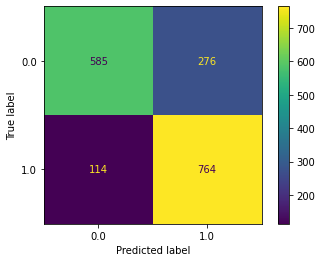

In [214]:
plot_confusion_matrix(pipeline_SVC,X_test,y_test)

In [215]:
y_pred_test_SVC = pipeline_SVC.predict(df_test)

In [216]:
y_pred_test_SVC

array([1., 0., 1., ..., 1., 1., 1.])

In [217]:
df_submission = pd.read_csv('/content/spaceship_titanic_sample_submission.csv')

In [218]:
# Sample Submission
output = pd.DataFrame({'PassengerId': df_submission.PassengerId, 'Transported': y_pred_test_SVC})
output.Transported.replace(0,False,inplace=True)
output.Transported.replace(1,True,inplace=True)

In [219]:
output.to_csv("/content/spaceship-titanic_prediction.csv", index = False)